<a href="https://colab.research.google.com/github/r-or/cnn-eyetrack-colab/blob/master/eyetrack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

eyetracker with feature extraction by CNNs

## Dimensions / features

* input: 1280x720 image

* feature extraction by [MTCNN](https://kpzhang93.github.io/MTCNN_face_detection_alignment/)

-> bounding boxes for eyes: scaled to** 48x(48 * 2)x3**

-> positional information: pixel coordinates **(x, y) x 2**


## TODO
* add feature: size of head could be interesting **(x, y, w, h)**
* performance: do bounding box extraction on scaled images and only then use high-res
* scale position / head size directly inside training data gen
* freeze model


# Flags

In [0]:
# Refresh all local data from google drive
REFRESH_DATA = False

# Requirements

## Packages

In [1]:
!pip3 install objsize tensorflow==2.0.0-beta1

     |████████████████████████████████| 87.9MB 50.0MB/s 
     |████████████████████████████████| 3.1MB 44.0MB/s 
     |████████████████████████████████| 501kB 50.2MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [2]:
!rm -rf mtcnn
!git clone --single-branch --branch tensorflow-2.0 https://github.com/r-or/mtcnn
!pip3 install -e mtcnn/

# NOW RESTART RUNTIME!

Cloning into 'mtcnn'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 141 (delta 0), reused 2 (delta 0), pack-reused 135
Receiving objects: 100% (141/141), 2.28 MiB | 1.25 MiB/s, done.
Resolving deltas: 100% (72/72), done.


## Utils

In [0]:
%load_ext tensorboard

import sys
import time
import numpy as np
import cv2
import urllib
from io import BytesIO
import PIL.Image
import IPython
import linecache
import tracemalloc

# utils
def _to_dict(dicts, by_key):
  d = {}
  for dic in dicts:
    d[dic[by_key]] = dic
    del d[dic[by_key]][by_key]
  return d


def _showarray(a, fmt='png'):
  # a way to display image in IPython that actually works
  a = np.uint8(a)
  a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  f = BytesIO()
  PIL.Image.fromarray(a).save(f, fmt)
  IPython.display.display(
    IPython.display.Image(data=f.getvalue(), 
                          width=min(800, a.shape[1])))
    
def _url_to_image(url):
	# download the image, convert it to a NumPy array, and then read
	# it into OpenCV format
	resp = urllib.request.urlopen(url)
	image = np.asarray(bytearray(resp.read()), dtype="uint8")
	image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  
	return image

def tracemalloc_display_top(snapshot, key_type='lineno', limit=10):
  snapshot = snapshot.filter_traces((
      tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
      tracemalloc.Filter(False, "<unknown>"),
  ))
  top_stats = snapshot.statistics(key_type)

  print("Top %s lines" % limit)
  for index, stat in enumerate(top_stats[:limit], 1):
    frame = stat.traceback[0]
    # replace "/path/to/module/file.py" with "module/file.py"
    filename = os.sep.join(frame.filename.split(os.sep)[-2:])
    print("#%s: %s:%s: %.1f KiB"
          % (index, filename, frame.lineno, stat.size / 1024))
    line = linecache.getline(frame.filename, frame.lineno).strip()
    if line:
      print('    %s' % line)

  other = top_stats[limit:]
  if other:
    size = sum(stat.size for stat in other)
    print("%s other: %.1f KiB" % (len(other), size / 1024))
  total = sum(stat.size for stat in top_stats)
  print("Total allocated size: %.1f KiB" % (total / 1024))
  
print_last_printtime = 0
print_last_txtlen = 0
def print_ln(txt, limit=True, clearline=False):
  global print_last_printtime
  global print_last_txtlen  
  
  if clearline and print_last_txtlen == 0:
    print('')
  
  if not limit or time.time() - print_last_printtime > .5:
    sys.stdout.write('\b' * print_last_txtlen + txt)
    sys.stdout.flush()
    print_last_txtlen = len(txt)
    print_last_printtime = time.time()
  
def print_ln_fin(txt=''):
  global print_last_textlen
  
  print_last_textlen = 0
  print(txt)

## Google Drive access & paths

In [5]:
import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# paths
drive_proj_root_dir = '/content/drive/My Drive/4proj/eyetrack'
dataset = 'actualrealset'  # dataset/ & dataset.json
modeldir = os.path.join(drive_proj_root_dir, 'models', dataset)

if not os.path.isdir('/content/eyetrack'):
  os.makedirs('/content/eyetrack')
  
try:
  print("Refresh: {}".format(REFRESH_DATA))
except NameError:
  REFRESH_DATA = False
  
%cd "/content/eyetrack"
if REFRESH_DATA:
  !rsync -rah "$drive_proj_root_dir/" "." --update --progress
  !7z x "./source_data/raw/*.zip" -osource_data/raw/ -r -y
else:
  # only copy npys and json
  !rsync -rah --include='*.json' --include='*.npy' --include='*/' \
      --exclude='*' "$drive_proj_root_dir" ".." --update --progress
  


Mounted at /content/drive
/content/eyetrack
sending incremental file list


# Generate training data

In [6]:
import os
import sys
import time
import pprint

import numpy as np
from mtcnn.mtcnn import MTCNN
from objsize import get_deep_size


pp = pprint.PrettyPrinter()
detector = MTCNN()

def gen_train_data(images, verbose=False, renderbbox=False):
  # generate labels for existing training data
  print('Processing...')
  training_set = {}
  for iidx, image in enumerate(images, 1):
    starttime = time.time()
    if image.startswith('http:') or image.startswith('https:'):
      img = _url_to_image(image)
    else:
      img = cv2.imread(image)

    if renderbbox:
      render = np.copy(img)
    prevtime = time.time()
    detections = detector.detect_faces(img)
    if verbose:
      print('Inference took {}s'.format(time.time() - prevtime))

      pp.pprint(detections)
      print('Image size:', img.shape)
    
      
    # Preprocessing
    prevtime = time.time()
    eyes = {'l': {'pos': None, 'patch': None}, 
            'r': {'pos': None, 'patch': None}
    }
      
    if detections:
      def sorting_metric(det):
        # conf^2 * box_width * box_height
        # -> take detection with biggest bounding box and ok confidence
        return det['confidence']**2 * det['box'][2] * det['box'][3]

      selection_idxs = sorted(enumerate(detections), 
                              key=lambda x: sorting_metric(x[1]))
      if verbose:
        print('selections:', 
              [(idx, sorting_metric(d)) for idx, d in enumerate(detections)])
      detection = detections[selection_idxs[0][0]]
      bbox1 = np.asarray(detection['box'][:2])
      bbox2 = bbox1 + np.asarray(detection['box'][2:])
      if renderbbox:
        cv2.rectangle(render, tuple(bbox1), tuple(bbox2), (227, 151, 38), 2)
      halfeyewidth = int((bbox2[0] - bbox1[0]) / 6)
      halfeyeheight = int(halfeyewidth)
      if verbose:
        print('eyesize: {}x{}'.format(2 * halfeyewidth, 2 * halfeyeheight))
      for eye in ['left_eye', 'right_eye']:
        pos = detection['keypoints'][eye]
        rec = [(pos[0] - halfeyewidth, pos[1] - halfeyeheight),
               (pos[0] + halfeyewidth, pos[1] + halfeyeheight)]
        eyes[eye[0]]['patch'] = np.array(img[rec[0][1] : rec[1][1], 
                                         rec[0][0] : rec[1][0], 
                                         :])
        eyes[eye[0]]['pos'] = pos
        if renderbbox:
          cv2.rectangle(render, rec[0], rec[1], (40, 150, 50), 2)

      training_set[os.path.basename(image)] = {'eyes': eyes}

    if verbose:
      print('Preprocessing took {}s'.format(time.time() - prevtime))
      
    if renderbbox:
      _showarray(render)
      for eye in ['l', 'r']:
        if eyes[eye]['pos']:
          print(eyes[eye]['pos'], '-> ' + eye)
          _showarray(eyes[eye]['patch'])

    print('{}/{} ({:.2f}%): {} | {} - {:.2f}img/s - {:.2f}MB'.format(
        iidx, len(images),
        100 * iidx / len(images),
        image, "OK" if detections else "NOPE",
        1 / (time.time() - starttime),
        get_deep_size(training_set) / 1e6))
    
    
  return training_set

W0729 04:26:48.042926 139969588844416 deprecation.py:323] From /content/mtcnn/mtcnn/layer_factory.py:224: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [0]:
import os
import json
import tracemalloc

dbg_mem = False
  
if REFRESH_DATA:
  if dbg_mem:
    tracemalloc.start()

  dataset_path = os.path.join('source_data/raw', dataset)

  train_images = [os.path.join(dataset_path, k) \
                  for k in os.listdir(dataset_path)]

  with open(dataset_path + '.json') as jsonfile:
    labels = json.load(jsonfile)

  if (len(labels) != len(train_images)):
    print('WARNING: there seems to be a discrepance between label file'
          'and the files themselves (labels: {}, images: {})'.format(
          len(labels), len(train_images)))

  train_data_all = gen_train_data(train_images, False, False)

  if dbg_mem:
    snapshot = tracemalloc.take_snapshot()
    tracemalloc_display_top(snapshot)


  for label in labels:
    if label['f'] in train_data_all:
      train_data_all[label['f']]['label'] = (label['x'], label['y'])


  if train_data_all:
    fname = os.path.join('source_data', dataset)
    np.save(fname, train_data_all)
    !cp "$fname.npy" "$drive_proj_root_dir/source_data/"
    print('Saved as {}.npy'.format(fname))
  
  
  

# Training the model

## Prepare dataset

In [0]:
import numpy as np
import json

import cv2
from tensorflow.keras import backend as K
import tensorflow as tf

np.random.seed(seed=69)
scale_x = 3840  # the maximum value in x direction for this dataset (pixels)
scale_y = 1080  # the maximum in y direction
img_res_x = 1280  # image resolution to scale eye positions
img_res_y = 720   # TODO: remove from here

split = 0.05  # percentage of validation data

# no augmentation for now, rotation etc is a component of the model
img_rows = 48
img_cols = 48
cnn_input_shape = (img_rows, 2 * img_cols, 3)  # lefteye + righteye, color

def prepare_dataset():
  global train_data_all
  global train_data_all_patches
  global train_data_all_positions
  global labels
  global val_samples
  global train_mask
  global validation_data_patches
  global train_data_patches
  global validation_data_positions
  global train_data_positions
  global validation_labels
  global train_labels
  
  train_data_all = np.load(os.path.join('source_data', dataset + '.npy'), 
                           allow_pickle=True)[()]

  for name, data in train_data_all.items():
    for side, eye in data['eyes'].items():
      train_data_all[name]['eyes'][side]['patch'] = cv2.resize(eye['patch'], 
                                                         (img_cols, img_rows))
    train_data_all[name]['eyepatch'] = np.concatenate(
        (train_data_all[name]['eyes']['l']['patch'], 
         train_data_all[name]['eyes']['r']['patch']), axis=1)

  train_data_all_patches = np.asarray(
      [v['eyepatch'] for k, v in sorted(train_data_all.items())], 
      dtype=np.float32) / 255.

  train_data_all_positions = np.asarray(
      [np.asarray((v['eyes']['l']['pos'][0] / img_res_x, 
                   v['eyes']['l']['pos'][1] / img_res_y, 
                   v['eyes']['r']['pos'][0] / img_res_x,
                   v['eyes']['r']['pos'][1] / img_res_y)) \
       for k, v in sorted(train_data_all.items())],
      dtype=np.float32)

  labels = np.asarray(
      [np.asarray((v['label'][0] / scale_x, v['label'][1] / scale_y)) \
       for k, v in sorted(train_data_all.items())],
      dtype=np.float32)

  # split training/validation set
  val_samples = np.random.randint(len(train_data_all.keys()), 
                                  size=int(split * len(train_data_all.keys())))
  train_mask = np.ones(len(train_data_all.keys()), np.bool)
  train_mask[val_samples] = False

  validation_data_patches = train_data_all_patches[val_samples]
  train_data_patches = train_data_all_patches[train_mask]

  validation_data_positions = train_data_all_positions[val_samples]
  train_data_positions = train_data_all_positions[train_mask]

  validation_labels = labels[val_samples]
  train_labels = labels[train_mask]

  assert len(validation_data_patches) == len(validation_data_positions) \
      == len(validation_labels), 'Something inexplicably went wrong.'

def get_checkpoints(directory):
  # list of (filename, epoch)
  return sorted([(file, int(file.split('_')[-1]
                            .split('-')[0]
                            .split('.')[-1]) - 1) \
                 for file in os.listdir(directory)], key=lambda x: x[1])

## Create Model

In [0]:

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, \
                                    Activation, Dropout, Dense, Flatten, \
                                      Input, concatenate

def create_model(cnn_input_shape, filters=(16, 32, 64, 128)):
  # input 1:
  input_a = Input(shape=cnn_input_shape)
  input_b = Input(shape=(4,))  # x, y Position of eyes
  
  channel_dim = -1

  for (i, f) in enumerate(filters):
    if i == 0:
      x = input_a
    
    # CONV => RELU => BN => POOL
    x = Conv2D(f, (3, 3), activation='relu')(x)
#     x = Activation('relu')(x)
    x = BatchNormalization(axis=channel_dim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(i * 0.1)(x)
    
  x = Flatten()(x)
  x = Dense(400, activation='relu')(x)
  x = Dense(300, activation='relu')(x)
  x = Dense(16, activation='relu')(x)
  x = BatchNormalization(axis=channel_dim)(x)
  x = Dropout(0.5)(x)
  
  # create 4 output nodes
  x = Dense(4)(x)
  x = Activation('relu')(x)  
  model_a = Model(input_a, x)
  
  y = Dense(4, activation='relu')(input_b)
  y = Dense(4, activation='relu')(y)
  model_b = Model(input_b, y)
  
  combined = concatenate([model_a.output, model_b.output])
  
  z = Dense(4, activation='relu')(combined)
  z = Dense(8, activation='relu')(z)
  z = Dense(4, activation='relu')(z)
  z = Dense(2, activation='linear')(z)
  
  model = Model(inputs=(model_a.input, model_b.input), outputs=z)
  
  return model
  

## Intermission
Visualize data & model

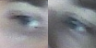

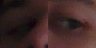

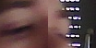

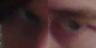

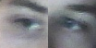

max/min input size: (48, 48) (48, 48)
patch shapes:
 val: (909, 48, 96, 3)
 train: (17316, 48, 96, 3)
 cnn input: (48, 96, 3)
position shapes:
 val: (909, 4)
 train: (17316, 4)


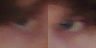

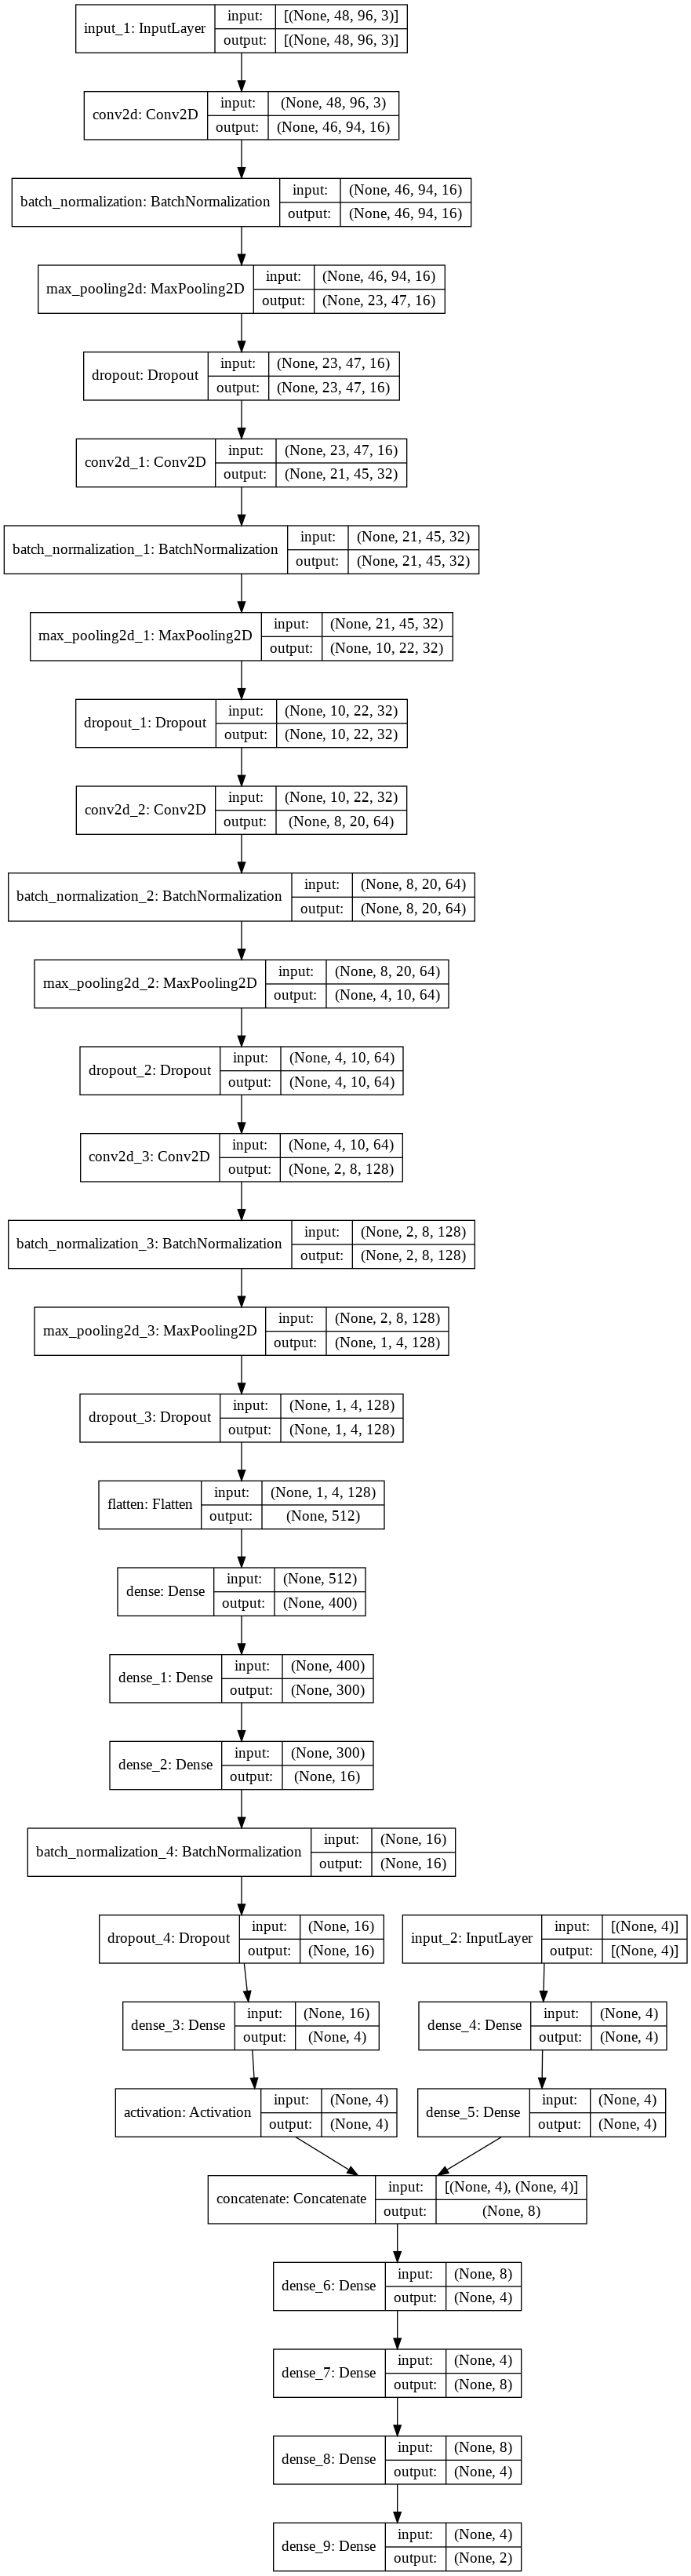

In [13]:
import tensorflow.keras.utils

prepare_dataset()

maxshape = (0, 0)
minshape = (1000, 1000)
oneeyenum = 0
twoeyenum = 0
for idx, (name, data) in enumerate(train_data_all.items()):
  for eye in data['eyes'].values():
    patchshape = eye['patch'].shape
    maxshape = (max(maxshape[0], patchshape[0]), max(maxshape[1], patchshape[1]))
    minshape = (min(maxshape[0], patchshape[0]), min(maxshape[1], patchshape[1]))
    
  if idx < 5:
    _showarray(data['eyepatch'])
    
print('max/min input size:', maxshape, minshape)
print('patch shapes:')
print(' val:', validation_data_patches.shape)
print(' train:', train_data_patches.shape)
print(' cnn input:', cnn_input_shape)
print('position shapes:')
print(' val:', validation_data_positions.shape)
print(' train:', train_data_positions.shape)
_showarray(train_data_patches[9999] * 255.)


model = create_model(cnn_input_shape)
IPython.display.display(tensorflow.keras.utils.plot_model(model, 
                                                          show_shapes=True))

## Training

In [14]:
%tensorboard --logdir "$drive_proj_root_dir/models/$dataset/logs"

In [0]:
import os
import datetime
from tensorflow.keras.optimizers import Adam, Adadelta, SGD
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import tensorflow as tf

# params = [
#     (Adam, "mean_absolute_percentage_error", (16, 32, 64), 32, 200, 1e-3, 1e-3 / 200),
# #     (Adam, "mean_absolute_percentage_error", (8, 16, 32), 32, 200, 1e-3, 1e-3 / 200),
# #     (Adam, "mean_absolute_percentage_error", (16, 32, 64, 128), 32, 200, 1e-3, 1e-3 / 200),
#     (Adam, "mean_absolute_percentage_error", (16, 32, 64, 256), 32, 200, 1e-3, 1e-3 / 200),
# #     (Adam, "mean_absolute_percentage_error", (64, 128, 256), 32, 200, 1e-3, 1e-3 / 200),
    
# #     (Adam, "mean_absolute_percentage_error", (16, 32, 64), 32, 200, 1, 1e-3 / 200),
# #     (Adam, "mean_absolute_percentage_error", (16, 32, 64), 32, 200, 1, 1 / 200),
# #     (Adam, "mean_absolute_percentage_error", (16, 32, 64), 32, 200, 1e-2, 1e-2 / 200),
# #     (Adam, "mean_absolute_percentage_error", (16, 32, 64), 32, 200, 10, 1 / 200),
    
#     (Adam, "mean_absolute_percentage_error", (16, 32, 64), 8, 200, 1e-3, 1e-3 / 200),
#     (Adam, "mean_absolute_percentage_error", (16, 32, 64), 1, 200, 1e-3, 1e-3 / 200),
    
#     (Adam, "mean_absolute_percentage_error", (16, 32, 64, 128), 32, 3000, 1e-3, 1e-3 / 200),
    
#     (Adadelta, "mean_absolute_percentage_error", (16, 32, 64), 32, 200, 1.0, 0.0),
#     (Adadelta, "mean_absolute_percentage_error", (8, 16, 32), 32, 200, 1.0, 0.0),
#     (Adadelta, "mean_absolute_percentage_error", (16, 32, 64, 128), 32, 200, 1.0, 0.0),
#     (Adadelta, "mean_absolute_percentage_error", (16, 32, 64, 256), 32, 200, 1.0, 0.0),
#     (Adadelta, "mean_absolute_percentage_error", (64, 128, 256), 32, 200, 1.0, 0.0),
#     (Adadelta, "mean_absolute_percentage_error", (4, 8, 16, 32, 64, 128), 32, 200, 1.0, 0.0),
    
#     (Adadelta, "mean_absolute_percentage_error", (16, 32, 64), 32, 3000, 1.0, 0.0),
#     (Adadelta, "mean_absolute_percentage_error", (16, 32, 64, 128), 32, 3000, 1.0, 0.0),
# ]

params = [
    # current champion: trained for ~ 1200 epochs, without reduce_lr
    (SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False), 
     "mse", 
     (16, 32, 64, 128), 
     32, 
     2000)
]

# appendix for name of run(s)
bla = 'denseX2+momentum'

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=10, verbose=1, 
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0001)

class LossHistory(tf.keras.callbacks.Callback):
  # to print information during training
  def on_epoch_end(self, epoch, logs={}):
    initial_lr = K.eval(self.model.optimizer.lr)
    initial_decay = K.eval(self.model.optimizer.decay)
    lr = initial_lr * (1. / (1. + initial_decay \
                             * K.eval(self.model.optimizer.iterations)))
    if self.last_lr != lr:
      print('LR changed to: {}'.format(lr))
      self.last_lr = lr
      
  def on_train_begin(self, logs={}):
    self.last_lr = 0
#     print_ln_fin()
      
#   def on_epoch_begin(self, epoch, logs={}):
#     self.epoch = epoch + 1
#     self.epoch_starttime = time.time()
# #     print('epoch_begin', epoch, logs)
    
#   def on_batch_end(self, batch, logs={}):
#     csample = (batch + 1) * self.params['batch_size']
#     print_ln('Epoch {}/{}, sample {}/{} => loss: {:.5f} | {:.2f}s/epoch'.format(
#         self.epoch, self.params['epochs'],
#         csample, 
#         self.params['samples'],
#         logs['loss'],
#         (time.time() - self.epoch_starttime) * self.params['samples'] / csample) + str(print_last_textlen), 
#       clearline=True)
    
#   def on_train_end(self, logs={}):
#     print_ln_fin()
    
print_callback = LossHistory() 


for opt, loss, filters, batch_size, epochs in params:
  
  prepare_dataset()

  run = "{}x{}-{}-{}@lr{:.5f}-de{:.5f}-cnn{}_{}_{}".format(
      epochs, batch_size, loss,
      str(type(opt)).split('.')[-1].split('\'')[0], 
      K.eval(opt.lr), K.eval(opt.decay),
      "+".join(str(k) for k in filters),
      bla,
      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),)
  
  model = None
  initial_epoch = 0
  # check if we can resume training
  if os.path.isdir(os.path.join(modeldir, 'chkp')):
    for existing_model in sorted(os.listdir(os.path.join(modeldir, 'chkp'))):
      if run.split('_')[0] == existing_model.split('_')[0]:
        if existing_model not in [k.split('.')[0] \
                                  for k in os.listdir(modeldir)]:
          # has not already been trained for all epochs
          chkpdir = os.path.join(modeldir, 'chkp', existing_model)
          chkpoints = get_checkpoints(chkpdir)
          if chkpoints:
            last_chkp, last_epoch = chkpoints[-1]
            print('Continue training from "{}"? (y/N)'.format(last_chkp))
            if input().lower() == 'y':
              run = existing_model
              model = load_model(os.path.join(chkpdir, last_chkp))
              print('Loaded model: {}'.format(last_chkp))
              initial_epoch = last_epoch
          else:
            print('No checkpoints available. Creating new model.')
            
        break
      
    # tensorboard log / callback
  logdir = os.path.join(drive_proj_root_dir, 'models', dataset, 'logs', run)
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, 
                                                        histogram_freq=1)
  
  # checkpoint callback
  chkpdir = os.path.join(modeldir, 'chkp', run)
  if not os.path.isdir(chkpdir):
    os.makedirs(chkpdir)
  chkp_callback = tf.keras.callbacks.ModelCheckpoint(
      os.path.join(chkpdir, run + '_chkp.{epoch:02d}-{val_loss:.5f}.h4'),
      monitor='val_loss', verbose=1, save_best_only=True, 
      save_weights_only=False, mode='auto', period=1)

  if not model:
    model = create_model(cnn_input_shape, filters=filters)    
  #   opt = optimizer(lr=learn_rate, decay=decay)
    model.compile(loss=loss, optimizer=opt)

  # train the model
  print("[INFO] training model: {} ...".format(run))
  model.fit(
      [train_data_patches, train_data_positions], 
      train_labels,
      validation_data=([validation_data_patches, validation_data_positions], 
                       validation_labels),
      epochs=epochs, 
      batch_size=batch_size,
      callbacks=[tensorboard_callback,
                 chkp_callback,
#                  reduce_lr_callback,
                 print_callback,
                ],
      initial_epoch=initial_epoch,
      verbose=1)

  if not os.path.isdir(modeldir):
    os.makedirs(modeldir)
  model.save(os.path.join(modeldir, run + '.h4'))

## Eval

Predicting /content/drive/My Drive/4proj/eyetrack/models/actualrealset/chkp/2000x32-mse-SGD@lr0.01000-de0.00000-cnn16+32+64+128_denseX2+momentum_20190513-090059/2000x32-mse-SGD@lr0.01000-de0.00000-cnn16+32+64+128_denseX2+momentum_20190513-090059_chkp.1284-0.00420.h4... 2250.872 µs / pass
Predicting /content/drive/My Drive/4proj/eyetrack/models/actualrealset/chkp/2000x32-mse-SGD@lr0.01000-de0.00000-cnn16+32+64+128_denseX2+momentum_20190513-091855/2000x32-mse-SGD@lr0.01000-de0.00000-cnn16+32+64+128_denseX2+momentum_20190513-091855_chkp.12-0.04911.h4... 2144.208 µs / pass
Result (best to worst): [modelname, mean squared error]
#1: [2000x32-mse-SGD@lr0.01000-de0.00000-cnn16+32+64+128_denseX2+momentum_20190513-090059_chkp.1284-0.00420.h4, 0.004099936637416793]
#2: [2000x32-mse-SGD@lr0.01000-de0.00000-cnn16+32+64+128_denseX2+momentum_20190513-091855_chkp.12-0.04911.h4, 0.04901875075202833]

The best 10:
#662: squared error 0.00001 -> pred (1834px, 420px) | actual (1820px, 420px)


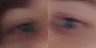

#50: squared error 0.00002 -> pred (911px, 325px) | actual (920px, 320px)


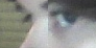

#551: squared error 0.00004 -> pred (3449px, 814px) | actual (3440px, 820px)


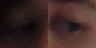

#269: squared error 0.00005 -> pred (1897px, 524px) | actual (1920px, 520px)


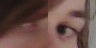

#741: squared error 0.00005 -> pred (2263px, 115px) | actual (2240px, 120px)


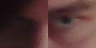

#348: squared error 0.00005 -> pred (2312px, 719px) | actual (2340px, 720px)


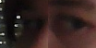

#244: squared error 0.00005 -> pred (1292px, 120px) | actual (1320px, 120px)


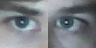

#425: squared error 0.00005 -> pred (418px, 912px) | actual (420px, 920px)


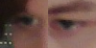

#443: squared error 0.00007 -> pred (2242px, 411px) | actual (2240px, 420px)


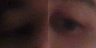

#491: squared error 0.00008 -> pred (1126px, 129px) | actual (1120px, 120px)


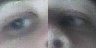


The mediocre 10:
#343: squared error 0.00551 -> pred (1059px, 98px) | actual (1120px, 20px)


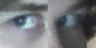

#672: squared error 0.00552 -> pred (1643px, 143px) | actual (1720px, 220px)


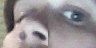

#328: squared error 0.00552 -> pred (756px, 651px) | actual (1020px, 620px)


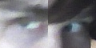

#127: squared error 0.00553 -> pred (406px, 494px) | actual (520px, 420px)


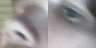

#799: squared error 0.00554 -> pred (1382px, 790px) | actual (1520px, 720px)


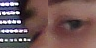

#545: squared error 0.00556 -> pred (406px, 516px) | actual (120px, 520px)


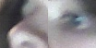

#754: squared error 0.00563 -> pred (3544px, 861px) | actual (3740px, 920px)


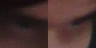

#219: squared error 0.00564 -> pred (3227px, 611px) | actual (2940px, 620px)


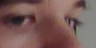

#39: squared error 0.00565 -> pred (2061px, 391px) | actual (1920px, 320px)


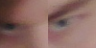

#648: squared error 0.00569 -> pred (2359px, 798px) | actual (2440px, 720px)


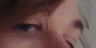


The worst 10:
#204: squared error 0.03327 -> pred (406px, 484px) | actual (20px, 320px)


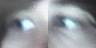

#879: squared error 0.03452 -> pred (3326px, 157px) | actual (3740px, 320px)


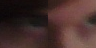

#281: squared error 0.03481 -> pred (403px, 390px) | actual (20px, 220px)


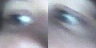

#38: squared error 0.03530 -> pred (409px, 691px) | actual (20px, 520px)


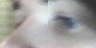

#812: squared error 0.05104 -> pred (3462px, 793px) | actual (3140px, 1020px)


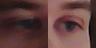

#703: squared error 0.05410 -> pred (1500px, 769px) | actual (1620px, 520px)


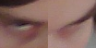

#357: squared error 0.05871 -> pred (407px, 571px) | actual (120px, 820px)


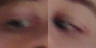

#9: squared error 0.08608 -> pred (1104px, 238px) | actual (1920px, 20px)


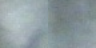

#692: squared error 0.09748 -> pred (2719px, 753px) | actual (2540px, 420px)


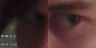

#52: squared error 0.11113 -> pred (1619px, 780px) | actual (1620px, 420px)


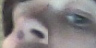

In [16]:
import sys
import os
import time

import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import mean_squared_error
import tensorflow.keras.backend as K
import tensorflow as tf

# cfg = tf.compat.v1.ConfigProto()
# cfg.gpu_options.allow_growth = True
# K.set_session(tf.compat.v1.Session(config=cfg))

prepare_dataset()

models2eval = []
for existing_model in os.listdir(os.path.join(modeldir, 'chkp')):
  chkpdir = os.path.join(modeldir, 'chkp', existing_model)
  checkpoints = get_checkpoints(chkpdir)
  if checkpoints:
    models2eval.append(os.path.join(chkpdir, checkpoints[-1][0]))
  
models2eval += [f for f in os.listdir(modeldir) if os.path.isfile(f)]
  
eval_results = []
for modelname in models2eval:
  sys.stdout.write('Predicting {}...'.format(modelname))
  model = load_model(os.path.join(modeldir, modelname))
  inference_start = time.time()
  preds = model.predict([validation_data_patches, validation_data_positions])
  print(' {:.3f} µs / pass'.format(
      1e6 * (time.time() - inference_start) / len(preds)))
  
  mse = np.array(mean_squared_error(validation_labels, preds))
  eval_results.append((os.path.basename(modelname), 
                       np.sum(mse) / len(mse),
                       preds))
  K.clear_session()
  del model
  
eval_results = sorted(eval_results, key=lambda x: (x[1], x[0]))

print('Result (best to worst): [modelname, mean squared error]')
for idx, ev in enumerate(eval_results, 1):
  print('#{}: [{}, {}]'.format(idx, *ev))

eval_results_scaled = []
for idx, (pred, actual, patch) in enumerate(
    zip(eval_results[0][2], validation_labels, validation_data_patches), 1):
  se = (pred[0] - actual[0]) ** 2 + (pred[1] - actual[1]) ** 2
  pred = (int(round(pred[0] * scale_x)), int(round(pred[1] * scale_y)))
  actual = (int(round(actual[0] * scale_x)), int(round(actual[1] * scale_y)))
  eval_results_scaled.append((idx, se, pred, actual, patch * 255))
  

for idx, (id, se, pred, actual, patch) in enumerate(
    sorted(eval_results_scaled, key=lambda x: x[1])):
  med = int(len(eval_results_scaled) / 2)
  if idx == 0:
    print('\nThe best 10:')
  elif idx == med - 5:
    print('\nThe mediocre 10:')
  elif idx == len(eval_results_scaled) - 11:
    print('\nThe worst 10:')
    
  if idx < 10 or (idx > med - 5 and idx <= med + 5) \
      or idx > len(eval_results_scaled) - 11: 
    print("#{}: squared error {:.5f} -> "
          "pred ({}px, {}px) | actual ({}px, {}px)".format(
        id, se, *(pred + actual)))
    _showarray(patch)



## Freeze model

In [0]:
!rm -r /content/drive/My\ Drive/4proj/eyetrack/models/logs/*

# Export notebook

In [0]:
!jupyter nbconvert --to=python "/content/drive/My Drive/Colab Notebooks/eyetrack.ipynb"
!jupyter nbconvert --to=html "/content/drive/My Drive/Colab Notebooks/eyetrack.ipynb"

[NbConvertApp] Converting notebook /content/drive/My Drive/Colab Notebooks/eyetrack.ipynb to python
[NbConvertApp] Writing 23929 bytes to /content/drive/My Drive/Colab Notebooks/eyetrack.py
[NbConvertApp] Converting notebook /content/drive/My Drive/Colab Notebooks/eyetrack.ipynb to html
/usr/local/lib/python2.7/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) [u'application/vnd.colab-display-data+json'] is not able to be represented.
  mimetypes=output.keys())
[NbConvertApp] Writing 670989 bytes to /content/drive/My Drive/Colab Notebooks/eyetrack.html
